# Pre-RA Flow PT1: Cell type level subclustering

Scaling, dimension reduction, UMAP, freq stats

## Setup

In [2]:
%config Completer.use_jedi = False
import scyan as sy
import os
import glob
import anndata
import re
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import scanpy as sc
import scanpy.external as sce
import copy
from concurrent.futures import ProcessPoolExecutor

print(sy.__version__)
print(anndata.__version__)


/home/jupyter/envs/libs/scyan/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Global seed set to 0


1.5.1
0.10.6


In [3]:
#### ==== parameter set up ==== ####
# define the working path
panel = "PT1"
# define l1 cell types to subset
cell_types = ["total_t_cells", "total_nk_cells"]

# define markers used for clustering
antigens = {
    "total_t_cells": ["CD56", "CD27", "CD38", "CD197 (CCR7)", "CD45RA", "CD127 (IL7Ra)", "CD25 (IL2Ra)",
"CD4", "CD8", "CD103", "CD223 (LAG3)", "CD278 (ICOS)", "CD39", "CD95", "KLRG1", "TIGIT","abTCR" ,"CD185 (CXCR5)",
"CD279 (PD-1)", "CD69" ,"HLA-DR"],
    "total_nk_cells": ["CD56",
                      "CD27",
                      "CD38",
                      "CD197 (CCR7)",
                      "CD45RA",
                      "CD127 (IL7Ra)",
                      "CD25 (IL2Ra)",
                      "CD8",
                      "CD103",
                      "CD223 (LAG3)",
                      "CD278 (ICOS)",
                      "CD39",
                      "CD95",
                      "KLRG1",
                      "TIGIT",
                      "CD185 (CXCR5)",
                      "CD279 (PD-1)",
                      "CD69"]
}


data_path='/home/jupyter/projects/pre-ra/flow/raw-data/' + panel + '/labelled-expr/cache/'
fig_path = '/home/jupyter/projects/pre-ra/flow/02-clustering/results/' + panel + '_celltype_subsample'  + "/"
proj_name = 'pre-ra_flow_clustering_' + panel
output_path = '/home/jupyter/projects/pre-ra/flow/02-clustering/data/' +panel + '/'

if not os.path.exists(fig_path): os.makedirs(fig_path)
    
if not os.path.exists(output_path): os.makedirs(output_path)

# define scanpy verbose levels
sc.settings.verbosity = 3
sc.settings.figdir = fig_path
sc.settings.n_jobs = -1

## Functions

In [4]:
def read_anndata_files(file_tuples):
    """
    Read Anndata objects from H5AD files and store them in a dictionary with custom names.

    Parameters:
        file_tuples (list of tuples): List of tuples where each tuple contains filename and desired name.

    Returns:
        dict: Dictionary containing Anndata objects with custom names.
    """
    anndata_dict = {}
    for filename, name in file_tuples:
        anndata_obj = anndata.read_h5ad(filename)
        anndata_dict[name] = anndata_obj
    return anndata_dict

In [5]:
def save_anndata_list(anndata_list, filenames):
    """
    Save a list of Anndata objects to separate H5AD files.

    Parameters:
        anndata_list (list): List of Anndata objects to be saved.
        filenames (list): List of filenames to save Anndata objects.

    Returns:
        None
    """
    # zip() combines two lists into a single tuple
    for anndata_obj, filename in zip(adata_downsampled_celltypes, filenames):
        print(adata_downsampled_celltypes[anndata_obj])
        adata_downsampled_celltypes[anndata_obj].write_h5ad(filename)

In [6]:
# make a function to find files
def get_filepaths_with_glob(root_path: str, file_regex: str):
    return glob.glob(os.path.join(root_path, file_regex))

In [7]:
#### parallelized leiden clustering
def run_leiden(adata, resolution, key_added):
    # Make a copy of adata for thread safety
    adata_copy = copy.deepcopy(adata)
    adata_clustering = sc.tl.leiden(adata_copy, resolution=resolution, key_added=key_added, copy=True)
    return adata_clustering.obs
 
def run_leiden_parallel(adata, tasks):
    with ProcessPoolExecutor(max_workers=5) as executor:
        # Make deep copies of adata for each task to ensure thread safety
        futures = [executor.submit(run_leiden, copy.deepcopy(adata), resolution, key_added) for resolution, key_added in tasks]
        
        results = [future.result() for future in futures]
 
    # Assign the results back to the original AnnData object
    for result, (_, key_added) in zip(results, tasks):
        adata.obs[key_added] = result[key_added]
 
    return adata

## Read in data

In [69]:
filenames = get_filepaths_with_glob(output_path, "adata_preprocess_unscaled_downsmpl_celltypes_*.h5ad")  
filenames

['/home/jupyter/projects/pre-ra/flow/02-clustering/data/PT1/adata_preprocess_unscaled_downsmpl_celltypes_total_t_cells_PT1.h5ad',
 '/home/jupyter/projects/pre-ra/flow/02-clustering/data/PT1/adata_preprocess_unscaled_downsmpl_celltypes_total_nk_cells_PT1.h5ad']

In [70]:
# Extract the cell types between "celltypes_" and "PT1.h5ad"
cell_types = [path.split('celltypes_')[1].split('_PT1.h5ad')[0] for path in filenames]
cell_types

['total_t_cells', 'total_nk_cells']

In [71]:
## turn filenames and cell types into tuple
file_tups = list(zip(filenames, cell_types))
file_tups

[('/home/jupyter/projects/pre-ra/flow/02-clustering/data/PT1/adata_preprocess_unscaled_downsmpl_celltypes_total_t_cells_PT1.h5ad',
  'total_t_cells'),
 ('/home/jupyter/projects/pre-ra/flow/02-clustering/data/PT1/adata_preprocess_unscaled_downsmpl_celltypes_total_nk_cells_PT1.h5ad',
  'total_nk_cells')]

In [72]:
adata_downsampled_celltypes = read_anndata_files(file_tups)
adata_downsampled_celltypes

{'total_t_cells': AnnData object with n_obs × n_vars = 5480000 × 25
     obs: 'Unnamed: 0', 'sample_id', 'cell_id', 'barcode', 'Time', 'SSC-W', 'SSC-H', 'SSC-A', 'FSC-W', 'FSC-H', 'FSC-A', 'SSC-B-W', 'SSC-B-H', 'SSC-B-A', 'Viability_logicle', 'labels', 'batch', 'panel', 'l1_labels', 'sample.sampleKitGuid', 'Status_Xsec', 'Status_Long', 'subject.biologicalSex', 'subject.subjectGuid', 'days_to_conversion', 'age_conv', 'bmi_conv', 'Age2023',
 'total_nk_cells': AnnData object with n_obs × n_vars = 4026789 × 25
     obs: 'Unnamed: 0', 'sample_id', 'cell_id', 'barcode', 'Time', 'SSC-W', 'SSC-H', 'SSC-A', 'FSC-W', 'FSC-H', 'FSC-A', 'SSC-B-W', 'SSC-B-H', 'SSC-B-A', 'Viability_logicle', 'labels', 'batch', 'panel', 'l1_labels', 'sample.sampleKitGuid', 'Status_Xsec', 'Status_Long', 'subject.biologicalSex', 'subject.subjectGuid', 'days_to_conversion', 'age_conv', 'bmi_conv', 'Age2023'}

In [73]:
## read in panel df
panel_df = pd.read_csv('/home/jupyter/projects/pre-ra/flow/raw-data/AIFI_flow_' + panel + '_panel_breakdown.csv')
panel_df.tail()

,fcs_colname,antigen,range,minRange,maxRange,marker_class,chn_type,backbone_markers,used_for_clustering
31,Comp-PE-Cy5-A,CD38,4194304,-111.000351,4193244.25,type,fluorchnls,False,Yes
32,Comp-PE-Cy7-A,CD197 (CCR7),4194304,-111.000351,4193244.25,type,fluorchnls,False,Yes
33,Comp-APC-A,CD69,4194304,-111.000351,4193244.25,type,fluorchnls,False,No
34,Comp-APC-R700-A,CD25 (IL2Ra),4194304,-111.000351,4193244.25,type,fluorchnls,False,Yes
35,Comp-APC-Fire 750-A,KLRG1,4194304,-111.000122,4192648.00,type,fluorchnls,False,Yes


## Clustering markers

In [74]:
for celltypes, markers in antigens.items():
    print("Key:", celltypes)
    print("Value:", markers)
    
    ## validate that clustering antigen markers present in panel df
    gating_antigens = panel_df.loc[panel_df['used_for_clustering']=='Yes', 'antigen']

    print(gating_antigens[~gating_antigens.isin(markers)])
    
    clust_antigens = [s + '_logicle' for s in markers]
    print(clust_antigens)
    
    antigens[celltypes] = clust_antigens
    
print(antigens)

Key: total_t_cells
Value: ['CD56', 'CD27', 'CD38', 'CD197 (CCR7)', 'CD45RA', 'CD127 (IL7Ra)', 'CD25 (IL2Ra)', 'CD4', 'CD8', 'CD103', 'CD223 (LAG3)', 'CD278 (ICOS)', 'CD39', 'CD95', 'KLRG1', 'TIGIT', 'abTCR', 'CD185 (CXCR5)', 'CD279 (PD-1)', 'CD69', 'HLA-DR']
10     CD3
11    CD45
Name: antigen, dtype: object
['CD56_logicle', 'CD27_logicle', 'CD38_logicle', 'CD197 (CCR7)_logicle', 'CD45RA_logicle', 'CD127 (IL7Ra)_logicle', 'CD25 (IL2Ra)_logicle', 'CD4_logicle', 'CD8_logicle', 'CD103_logicle', 'CD223 (LAG3)_logicle', 'CD278 (ICOS)_logicle', 'CD39_logicle', 'CD95_logicle', 'KLRG1_logicle', 'TIGIT_logicle', 'abTCR_logicle', 'CD185 (CXCR5)_logicle', 'CD279 (PD-1)_logicle', 'CD69_logicle', 'HLA-DR_logicle']
Key: total_nk_cells
Value: ['CD56', 'CD27', 'CD38', 'CD197 (CCR7)', 'CD45RA', 'CD127 (IL7Ra)', 'CD25 (IL2Ra)', 'CD8', 'CD103', 'CD223 (LAG3)', 'CD278 (ICOS)', 'CD39', 'CD95', 'KLRG1', 'TIGIT', 'CD185 (CXCR5)', 'CD279 (PD-1)', 'CD69']
10       CD3
11      CD45
18     abTCR
27       CD4
28 

In [75]:
for label, sub_adata in adata_downsampled_celltypes.items():
    print("Key:", label)
    print("Value:", sub_adata)
    
    sub_adata.var['antigens'] = sub_adata.var.index.str.replace('_logicle', '')

    sub_adata.var[['gating_antigens']] = False
    sub_adata.var.loc[sub_adata.var.index.isin(antigens[label]),'gating_antigens'] = True
    sub_adata.var[['highly_variable']] = sub_adata.var[['gating_antigens']]
    print(sub_adata.var)
    
    adata_downsampled_celltypes[label] = sub_adata
    

Key: total_t_cells
Value: AnnData object with n_obs × n_vars = 5480000 × 25
    obs: 'Unnamed: 0', 'sample_id', 'cell_id', 'barcode', 'Time', 'SSC-W', 'SSC-H', 'SSC-A', 'FSC-W', 'FSC-H', 'FSC-A', 'SSC-B-W', 'SSC-B-H', 'SSC-B-A', 'Viability_logicle', 'labels', 'batch', 'panel', 'l1_labels', 'sample.sampleKitGuid', 'Status_Xsec', 'Status_Long', 'subject.biologicalSex', 'subject.subjectGuid', 'days_to_conversion', 'age_conv', 'bmi_conv', 'Age2023'
                            antigens  gating_antigens  highly_variable
CD3_logicle                      CD3            False            False
CD45_logicle                    CD45            False            False
CD56_logicle                    CD56             True             True
CD19_logicle                    CD19            False            False
CD27_logicle                    CD27             True             True
CD8_logicle                      CD8             True             True
CD39_logicle                    CD39             True 

In [76]:
adata_downsampled_celltypes['total_t_cells'].X

array([[2.6271918 , 3.8937519 , 1.3471829 , ..., 0.91546685, 1.4555465 ,
        1.2176025 ],
       [3.1484888 , 4.0266027 , 1.3587689 , ..., 0.8240147 , 1.7419077 ,
        1.256253  ],
       [3.0759234 , 3.9431503 , 1.3607076 , ..., 1.2400341 , 2.2610326 ,
        1.3739525 ],
       ...,
       [2.606041  , 3.8411348 , 1.4657235 , ..., 1.7109218 , 1.3246387 ,
        1.4769434 ],
       [2.9089587 , 3.971383  , 1.6566939 , ..., 1.2320195 , 0.6238513 ,
        2.690036  ],
       [2.6654663 , 3.9950037 , 1.5823317 , ..., 1.342176  , 1.3775773 ,
        2.6378427 ]], dtype=float32)

In [77]:
adata_downsampled_celltypes

{'total_t_cells': AnnData object with n_obs × n_vars = 5480000 × 25
     obs: 'Unnamed: 0', 'sample_id', 'cell_id', 'barcode', 'Time', 'SSC-W', 'SSC-H', 'SSC-A', 'FSC-W', 'FSC-H', 'FSC-A', 'SSC-B-W', 'SSC-B-H', 'SSC-B-A', 'Viability_logicle', 'labels', 'batch', 'panel', 'l1_labels', 'sample.sampleKitGuid', 'Status_Xsec', 'Status_Long', 'subject.biologicalSex', 'subject.subjectGuid', 'days_to_conversion', 'age_conv', 'bmi_conv', 'Age2023'
     var: 'antigens', 'gating_antigens', 'highly_variable',
 'total_nk_cells': AnnData object with n_obs × n_vars = 4026789 × 25
     obs: 'Unnamed: 0', 'sample_id', 'cell_id', 'barcode', 'Time', 'SSC-W', 'SSC-H', 'SSC-A', 'FSC-W', 'FSC-H', 'FSC-A', 'SSC-B-W', 'SSC-B-H', 'SSC-B-A', 'Viability_logicle', 'labels', 'batch', 'panel', 'l1_labels', 'sample.sampleKitGuid', 'Status_Xsec', 'Status_Long', 'subject.biologicalSex', 'subject.subjectGuid', 'days_to_conversion', 'age_conv', 'bmi_conv', 'Age2023'
     var: 'antigens', 'gating_antigens', 'highly_variab

# Scale, PCA, Harmonzie, UMAP

## Scale and PCA

Key: total_t_cells
Value: AnnData object with n_obs × n_vars = 5480000 × 25
    obs: 'Unnamed: 0', 'sample_id', 'cell_id', 'barcode', 'Time', 'SSC-W', 'SSC-H', 'SSC-A', 'FSC-W', 'FSC-H', 'FSC-A', 'SSC-B-W', 'SSC-B-H', 'SSC-B-A', 'Viability_logicle', 'labels', 'batch', 'panel', 'l1_labels', 'sample.sampleKitGuid', 'Status_Xsec', 'Status_Long', 'subject.biologicalSex', 'subject.subjectGuid', 'days_to_conversion', 'age_conv', 'bmi_conv', 'Age2023'
    var: 'antigens', 'gating_antigens', 'highly_variable'


[INFO] (scyan.preprocess) Data will be centered and standardised. This is advised only when using spectral/flow data (if this is not your case, consider running 'asinh_transform' instead of 'auto_logicle_transform').


computing PCA
    on highly variable genes
    with n_comps=20
    finished (0:00:06)


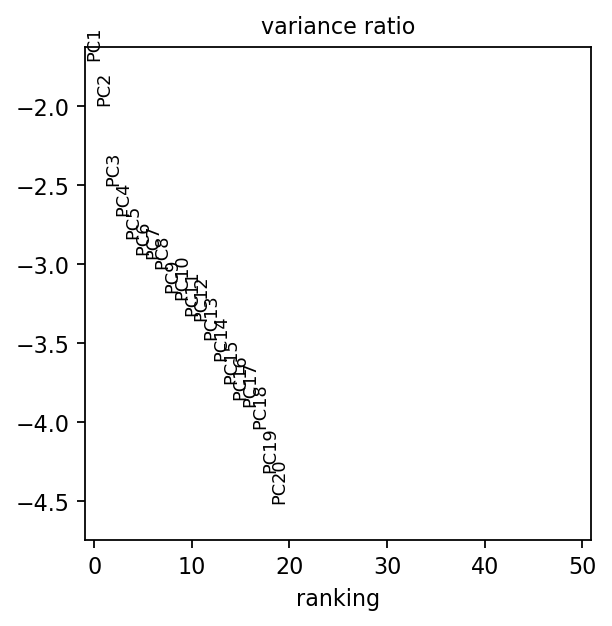

AnnData object with n_obs × n_vars = 5480000 × 25
    obs: 'Unnamed: 0', 'sample_id', 'cell_id', 'barcode', 'Time', 'SSC-W', 'SSC-H', 'SSC-A', 'FSC-W', 'FSC-H', 'FSC-A', 'SSC-B-W', 'SSC-B-H', 'SSC-B-A', 'Viability_logicle', 'labels', 'batch', 'panel', 'l1_labels', 'sample.sampleKitGuid', 'Status_Xsec', 'Status_Long', 'subject.biologicalSex', 'subject.subjectGuid', 'days_to_conversion', 'age_conv', 'bmi_conv', 'Age2023'
    var: 'antigens', 'gating_antigens', 'highly_variable'
    uns: 'scyan_scaling_stds', 'scyan_scaling_means', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
Key: total_nk_cells
Value: AnnData object with n_obs × n_vars = 4026789 × 25
    obs: 'Unnamed: 0', 'sample_id', 'cell_id', 'barcode', 'Time', 'SSC-W', 'SSC-H', 'SSC-A', 'FSC-W', 'FSC-H', 'FSC-A', 'SSC-B-W', 'SSC-B-H', 'SSC-B-A', 'Viability_logicle', 'labels', 'batch', 'panel', 'l1_labels', 'sample.sampleKitGuid', 'Status_Xsec', 'Status_Long', 'subject.biologicalSex', 'subject.subjectGuid', 'days_to_conversion', 'age_conv

[INFO] (scyan.preprocess) Data will be centered and standardised. This is advised only when using spectral/flow data (if this is not your case, consider running 'asinh_transform' instead of 'auto_logicle_transform').


computing PCA
    on highly variable genes
    with n_comps=17
    finished (0:00:03)


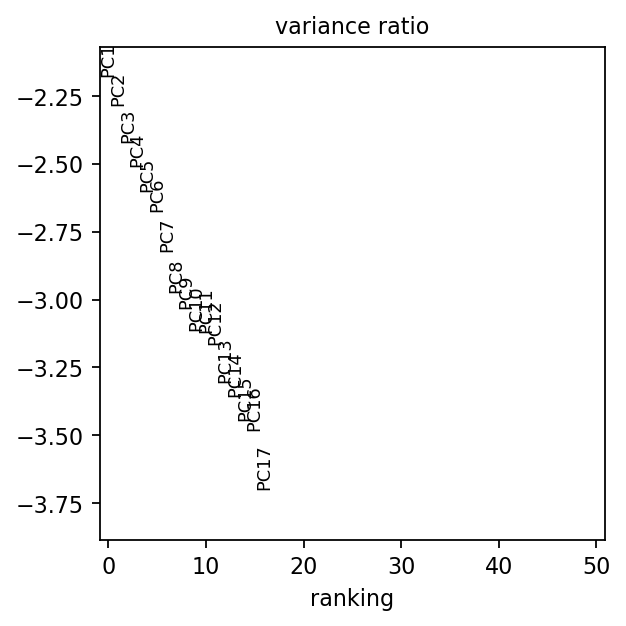

AnnData object with n_obs × n_vars = 4026789 × 25
    obs: 'Unnamed: 0', 'sample_id', 'cell_id', 'barcode', 'Time', 'SSC-W', 'SSC-H', 'SSC-A', 'FSC-W', 'FSC-H', 'FSC-A', 'SSC-B-W', 'SSC-B-H', 'SSC-B-A', 'Viability_logicle', 'labels', 'batch', 'panel', 'l1_labels', 'sample.sampleKitGuid', 'Status_Xsec', 'Status_Long', 'subject.biologicalSex', 'subject.subjectGuid', 'days_to_conversion', 'age_conv', 'bmi_conv', 'Age2023'
    var: 'antigens', 'gating_antigens', 'highly_variable'
    uns: 'scyan_scaling_stds', 'scyan_scaling_means', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
CPU times: user 1min 44s, sys: 1min 48s, total: 3min 33s
Wall time: 13.1 s


In [78]:
%%time
for label, sub_adata in adata_downsampled_celltypes.items():
    print("Key:", label)
    print("Value:", sub_adata)
    
    sy.preprocess.scale(sub_adata)
    # stored in .var['highly_variable']
    sc.pp.pca(sub_adata, svd_solver="arpack", use_highly_variable=True)
    sc.pl.pca_variance_ratio(sub_adata, log=True, n_pcs=50, save='pca_var_' +label+'.png') # scanpy generates the filename automatically
    
    print(sub_adata)
    
    # store back to dict
    adata_downsampled_celltypes[label] = sub_adata

## Harmonize

In [79]:
%%time
for label, sub_adata in adata_downsampled_celltypes.items():
    print("Key:", label)
    print("Value:", sub_adata)
    
    # perform batch correction
    sce.pp.harmony_integrate(sub_adata, 'batch', adjusted_basis='X_pca_harmony')
    
    # replace new pca slot
    sub_adata.obsm['X_pca'] = sub_adata.obsm['X_pca_harmony']
    
    print(sub_adata)
    
    # store back to dict
    adata_downsampled_celltypes[label] = sub_adata

Key: total_t_cells
Value: AnnData object with n_obs × n_vars = 5480000 × 25
    obs: 'Unnamed: 0', 'sample_id', 'cell_id', 'barcode', 'Time', 'SSC-W', 'SSC-H', 'SSC-A', 'FSC-W', 'FSC-H', 'FSC-A', 'SSC-B-W', 'SSC-B-H', 'SSC-B-A', 'Viability_logicle', 'labels', 'batch', 'panel', 'l1_labels', 'sample.sampleKitGuid', 'Status_Xsec', 'Status_Long', 'subject.biologicalSex', 'subject.subjectGuid', 'days_to_conversion', 'age_conv', 'bmi_conv', 'Age2023'
    var: 'antigens', 'gating_antigens', 'highly_variable'
    uns: 'scyan_scaling_stds', 'scyan_scaling_means', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'


2024-04-17 08:58:45,037 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-04-17 10:07:01,440 - harmonypy - INFO - Iteration 2 of 10
2024-04-17 10:52:03,287 - harmonypy - INFO - Iteration 3 of 10
2024-04-17 11:36:23,154 - harmonypy - INFO - Iteration 4 of 10
2024-04-17 11:56:54,362 - harmonypy - INFO - Iteration 5 of 10
2024-04-17 12:13:10,577 - harmonypy - INFO - Iteration 6 of 10
2024-04-17 12:26:45,691 - harmonypy - INFO - Iteration 7 of 10
2024-04-17 12:40:25,392 - harmonypy - INFO - Iteration 8 of 10
2024-04-17 12:54:04,235 - harmonypy - INFO - Converged after 8 iterations


AnnData object with n_obs × n_vars = 5480000 × 25
    obs: 'Unnamed: 0', 'sample_id', 'cell_id', 'barcode', 'Time', 'SSC-W', 'SSC-H', 'SSC-A', 'FSC-W', 'FSC-H', 'FSC-A', 'SSC-B-W', 'SSC-B-H', 'SSC-B-A', 'Viability_logicle', 'labels', 'batch', 'panel', 'l1_labels', 'sample.sampleKitGuid', 'Status_Xsec', 'Status_Long', 'subject.biologicalSex', 'subject.subjectGuid', 'days_to_conversion', 'age_conv', 'bmi_conv', 'Age2023'
    var: 'antigens', 'gating_antigens', 'highly_variable'
    uns: 'scyan_scaling_stds', 'scyan_scaling_means', 'pca'
    obsm: 'X_pca', 'X_pca_harmony'
    varm: 'PCs'
Key: total_nk_cells
Value: AnnData object with n_obs × n_vars = 4026789 × 25
    obs: 'Unnamed: 0', 'sample_id', 'cell_id', 'barcode', 'Time', 'SSC-W', 'SSC-H', 'SSC-A', 'FSC-W', 'FSC-H', 'FSC-A', 'SSC-B-W', 'SSC-B-H', 'SSC-B-A', 'Viability_logicle', 'labels', 'batch', 'panel', 'l1_labels', 'sample.sampleKitGuid', 'Status_Xsec', 'Status_Long', 'subject.biologicalSex', 'subject.subjectGuid', 'days_to_conve

2024-04-17 12:54:05,508 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-04-17 13:11:03,229 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-04-17 13:11:17,831 - harmonypy - INFO - Iteration 1 of 10
2024-04-17 13:38:09,376 - harmonypy - INFO - Iteration 2 of 10
2024-04-17 14:05:15,325 - harmonypy - INFO - Iteration 3 of 10
2024-04-17 14:32:48,326 - harmonypy - INFO - Iteration 4 of 10
2024-04-17 15:00:14,203 - harmonypy - INFO - Iteration 5 of 10
2024-04-17 15:25:45,065 - harmonypy - INFO - Iteration 6 of 10
2024-04-17 15:42:12,413 - harmonypy - INFO - Iteration 7 of 10
2024-04-17 16:01:55,518 - harmonypy - INFO - Iteration 8 of 10
2024-04-17 16:17:23,488 - harmonypy - INFO - Iteration 9 of 10
2024-04-17 16:34:13,206 - harmonypy - INFO - Converged after 9 iterations


AnnData object with n_obs × n_vars = 4026789 × 25
    obs: 'Unnamed: 0', 'sample_id', 'cell_id', 'barcode', 'Time', 'SSC-W', 'SSC-H', 'SSC-A', 'FSC-W', 'FSC-H', 'FSC-A', 'SSC-B-W', 'SSC-B-H', 'SSC-B-A', 'Viability_logicle', 'labels', 'batch', 'panel', 'l1_labels', 'sample.sampleKitGuid', 'Status_Xsec', 'Status_Long', 'subject.biologicalSex', 'subject.subjectGuid', 'days_to_conversion', 'age_conv', 'bmi_conv', 'Age2023'
    var: 'antigens', 'gating_antigens', 'highly_variable'
    uns: 'scyan_scaling_stds', 'scyan_scaling_means', 'pca'
    obsm: 'X_pca', 'X_pca_harmony'
    varm: 'PCs'
CPU times: user 1d 9h 33min 7s, sys: 1d 7h 55min 16s, total: 2d 17h 28min 23s
Wall time: 7h 35min 29s


## Neighbors, UMAP

In [80]:
print(antigens)

{'total_t_cells': ['CD56_logicle', 'CD27_logicle', 'CD38_logicle', 'CD197 (CCR7)_logicle', 'CD45RA_logicle', 'CD127 (IL7Ra)_logicle', 'CD25 (IL2Ra)_logicle', 'CD4_logicle', 'CD8_logicle', 'CD103_logicle', 'CD223 (LAG3)_logicle', 'CD278 (ICOS)_logicle', 'CD39_logicle', 'CD95_logicle', 'KLRG1_logicle', 'TIGIT_logicle', 'abTCR_logicle', 'CD185 (CXCR5)_logicle', 'CD279 (PD-1)_logicle', 'CD69_logicle', 'HLA-DR_logicle'], 'total_nk_cells': ['CD56_logicle', 'CD27_logicle', 'CD38_logicle', 'CD197 (CCR7)_logicle', 'CD45RA_logicle', 'CD127 (IL7Ra)_logicle', 'CD25 (IL2Ra)_logicle', 'CD8_logicle', 'CD103_logicle', 'CD223 (LAG3)_logicle', 'CD278 (ICOS)_logicle', 'CD39_logicle', 'CD95_logicle', 'KLRG1_logicle', 'TIGIT_logicle', 'CD185 (CXCR5)_logicle', 'CD279 (PD-1)_logicle', 'CD69_logicle']}


Key: total_t_cells
Value: AnnData object with n_obs × n_vars = 5480000 × 25
    obs: 'Unnamed: 0', 'sample_id', 'cell_id', 'barcode', 'Time', 'SSC-W', 'SSC-H', 'SSC-A', 'FSC-W', 'FSC-H', 'FSC-A', 'SSC-B-W', 'SSC-B-H', 'SSC-B-A', 'Viability_logicle', 'labels', 'batch', 'panel', 'l1_labels', 'sample.sampleKitGuid', 'Status_Xsec', 'Status_Long', 'subject.biologicalSex', 'subject.subjectGuid', 'days_to_conversion', 'age_conv', 'bmi_conv', 'Age2023'
    var: 'antigens', 'gating_antigens', 'highly_variable'
    uns: 'scyan_scaling_stds', 'scyan_scaling_means', 'pca', 'neighbors'
    obsm: 'X_pca', 'X_pca_harmony'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:14:59)
The clustering markers used for cell type: total_t_cells  is: ['CD56_logicle', 'CD27_logicle', 'CD38_logicle', 'CD197 (CCR7)_logicle', '

[INFO] (scyan.tools.representation) Fitting UMAP...
/home/jupyter/envs/libs/scyan/lib/python3.9/site-packages/scyan/plot/_scanpy_plot/umap.py:885: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/jupyter/envs/libs/scyan/lib/python3.9/site-packages/scyan/plot/_scanpy_plot/umap.py:885: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/jupyter/envs/libs/scyan/lib/python3.9/site-packages/scyan/plot/_scanpy_plot/umap.py:885: FutureWarning: The default value of 'ignore' for the `na_action` parameter in p

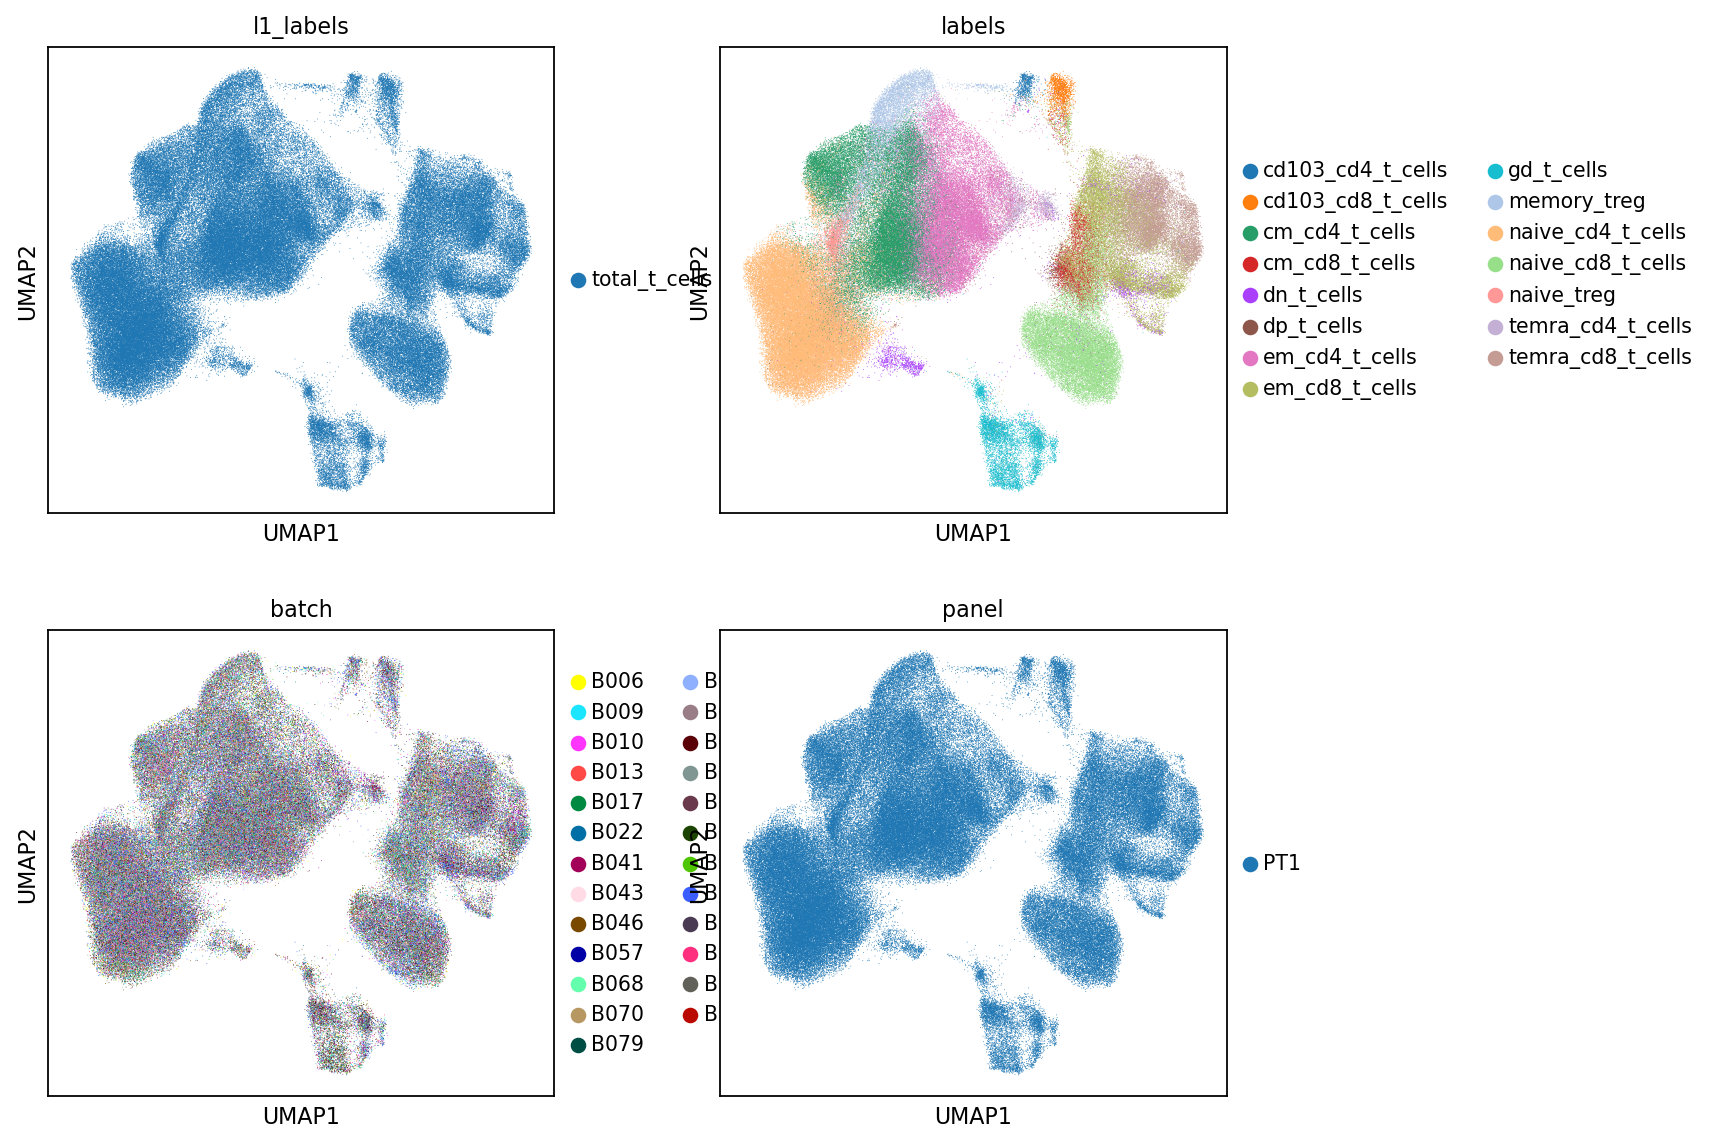

Key: total_nk_cells
Value: AnnData object with n_obs × n_vars = 4026789 × 25
    obs: 'Unnamed: 0', 'sample_id', 'cell_id', 'barcode', 'Time', 'SSC-W', 'SSC-H', 'SSC-A', 'FSC-W', 'FSC-H', 'FSC-A', 'SSC-B-W', 'SSC-B-H', 'SSC-B-A', 'Viability_logicle', 'labels', 'batch', 'panel', 'l1_labels', 'sample.sampleKitGuid', 'Status_Xsec', 'Status_Long', 'subject.biologicalSex', 'subject.subjectGuid', 'days_to_conversion', 'age_conv', 'bmi_conv', 'Age2023'
    var: 'antigens', 'gating_antigens', 'highly_variable'
    uns: 'scyan_scaling_stds', 'scyan_scaling_means', 'pca'
    obsm: 'X_pca', 'X_pca_harmony'
    varm: 'PCs'
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:10:38)
The clustering markers used for cell type: total_nk_cells  is: ['CD56_logicle', 'CD27_logicle', 'CD38_logicle', 'CD197 (CCR7)_logicle', 'CD45RA_logicle', 'CD127 (IL7Ra)_logicle', 'CD25 (IL

[INFO] (scyan.tools.representation) Fitting UMAP...
/home/jupyter/envs/libs/scyan/lib/python3.9/site-packages/scyan/plot/_scanpy_plot/umap.py:885: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/jupyter/envs/libs/scyan/lib/python3.9/site-packages/scyan/plot/_scanpy_plot/umap.py:885: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/jupyter/envs/libs/scyan/lib/python3.9/site-packages/scyan/plot/_scanpy_plot/umap.py:885: FutureWarning: The default value of 'ignore' for the `na_action` parameter in p

In [ ]:
%%time
for label, sub_adata in adata_downsampled_celltypes.items():
    print("Key:", label)
    print("Value:", sub_adata)
    
    # Perform re-clustering on the subset
    sc.pp.neighbors(sub_adata, n_neighbors=20, use_rep='X_pca_harmony')
    
    # skip leiden until parallelization
    print("The clustering markers used for cell type: " + label, " is: " + str(antigens[label]))
    sy.tools.umap(sub_adata, obsm='X_pca_harmony',markers=antigens[label])
    
    
    p1=sy.plot.umap(sub_adata, color=['l1_labels','labels', 'batch','panel'], ncols =2, return_fig = True)
    p1.savefig(fig_path + label + "_umap_labels_batch_panel_" +panel + ".png",
               dpi=400, bbox_inches='tight')
    
    marker_umap  = sc.pl.umap(sub_adata, color=sub_adata.var_names.sort_values(),ncols=6, show=True, return_fig=True, size=.5)
    marker_umap.set_size_inches(18.5, 18.5)
    marker_umap.savefig(fig_path + label + "_umap_expression_labels_corrected_panel_" +panel + ".png")

    # store back to dict
    adata_downsampled_celltypes[label] = sub_adata

Key: total_t_cells
Value: AnnData object with n_obs × n_vars = 5480000 × 25
    obs: 'Unnamed: 0', 'sample_id', 'cell_id', 'barcode', 'Time', 'SSC-W', 'SSC-H', 'SSC-A', 'FSC-W', 'FSC-H', 'FSC-A', 'SSC-B-W', 'SSC-B-H', 'SSC-B-A', 'Viability_logicle', 'labels', 'batch', 'panel', 'l1_labels', 'sample.sampleKitGuid', 'Status_Xsec', 'Status_Long', 'subject.biologicalSex', 'subject.subjectGuid', 'days_to_conversion', 'age_conv', 'bmi_conv', 'Age2023'
    var: 'antigens', 'gating_antigens', 'highly_variable'
    uns: 'scyan_scaling_stds', 'scyan_scaling_means', 'pca', 'neighbors'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'


/home/jupyter/envs/libs/scyan/lib/python3.9/site-packages/scyan/plot/_scanpy_plot/umap.py:885: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/jupyter/envs/libs/scyan/lib/python3.9/site-packages/scyan/plot/_scanpy_plot/umap.py:885: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


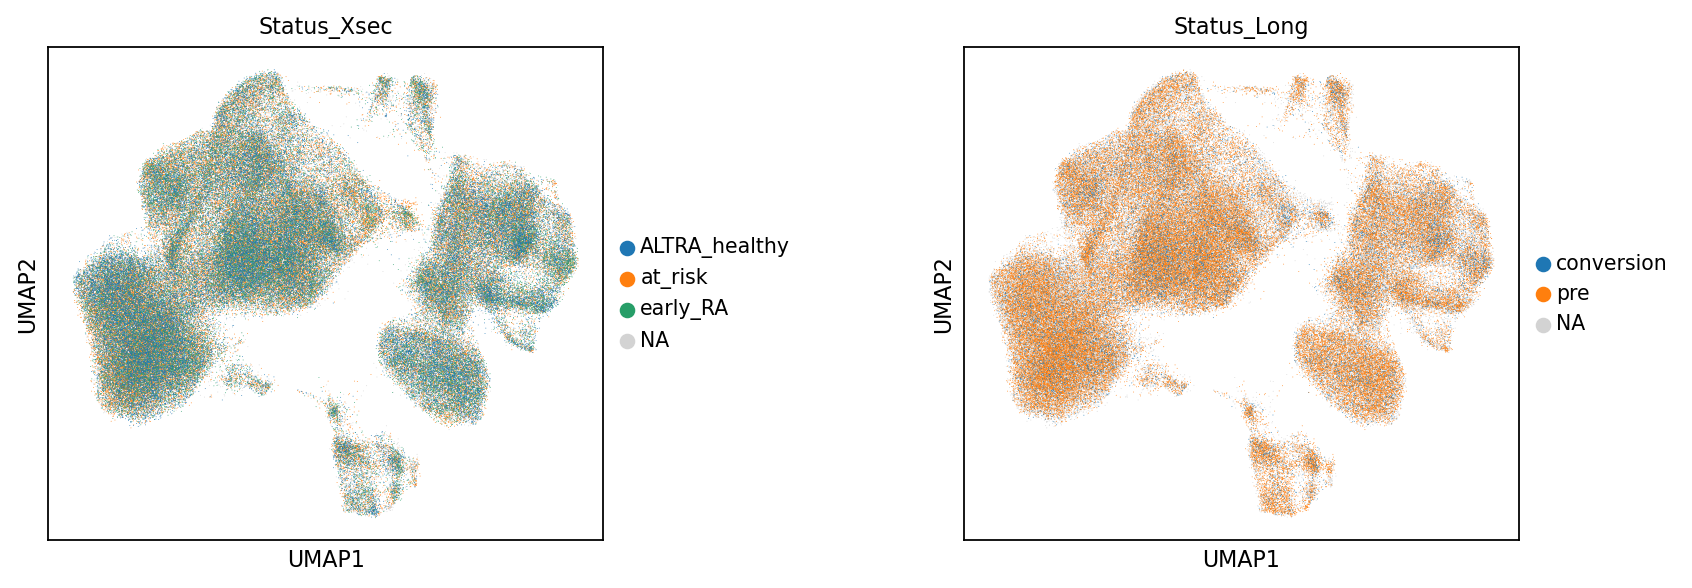

Key: total_nk_cells
Value: AnnData object with n_obs × n_vars = 4026789 × 25
    obs: 'Unnamed: 0', 'sample_id', 'cell_id', 'barcode', 'Time', 'SSC-W', 'SSC-H', 'SSC-A', 'FSC-W', 'FSC-H', 'FSC-A', 'SSC-B-W', 'SSC-B-H', 'SSC-B-A', 'Viability_logicle', 'labels', 'batch', 'panel', 'l1_labels', 'sample.sampleKitGuid', 'Status_Xsec', 'Status_Long', 'subject.biologicalSex', 'subject.subjectGuid', 'days_to_conversion', 'age_conv', 'bmi_conv', 'Age2023'
    var: 'antigens', 'gating_antigens', 'highly_variable'
    uns: 'scyan_scaling_stds', 'scyan_scaling_means', 'pca', 'neighbors'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'


/home/jupyter/envs/libs/scyan/lib/python3.9/site-packages/scyan/plot/_scanpy_plot/umap.py:885: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/jupyter/envs/libs/scyan/lib/python3.9/site-packages/scyan/plot/_scanpy_plot/umap.py:885: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


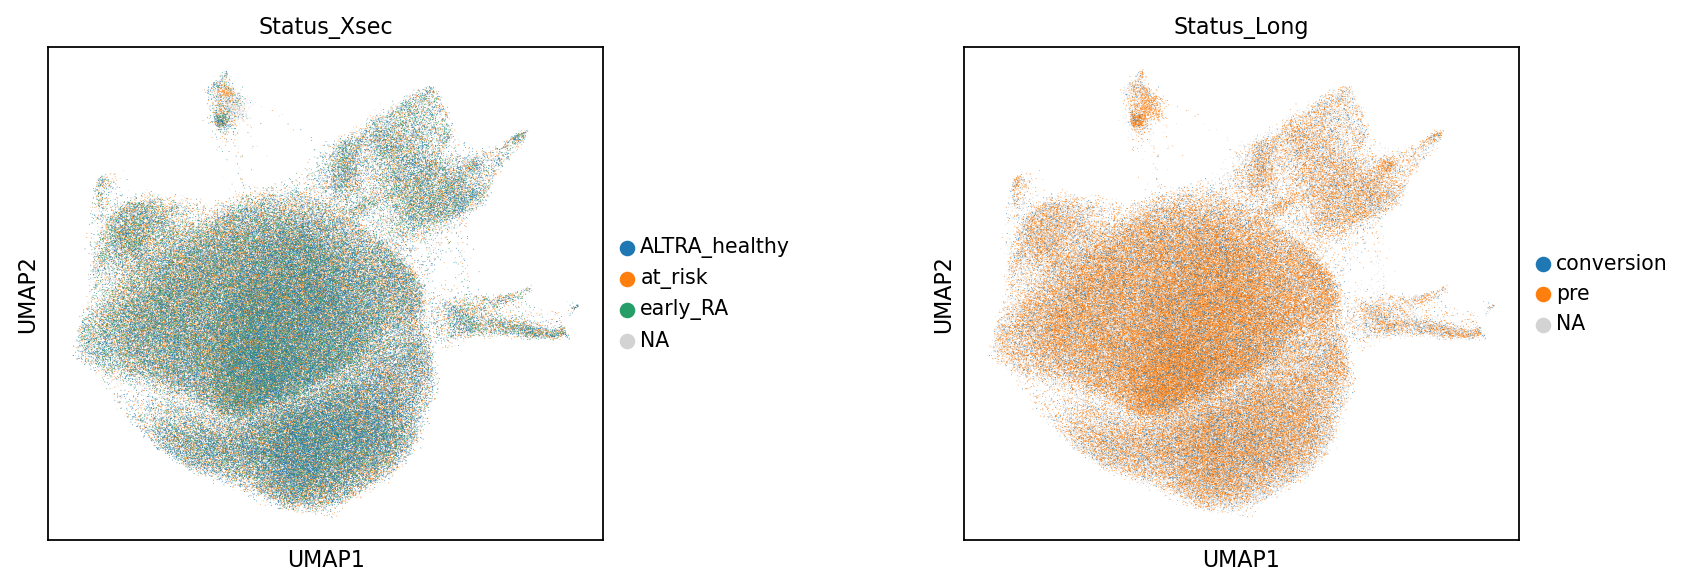

CPU times: user 9.02 s, sys: 631 ms, total: 9.65 s
Wall time: 8.91 s


In [86]:
%%time
for label, sub_adata in adata_downsampled_celltypes.items():
    print("Key:", label)
    print("Value:", sub_adata)
    p1=sy.plot.umap(sub_adata, color=['Status_Xsec', 'Status_Long'], ncols =2, return_fig = True,  wspace=.5)
    p1.savefig(fig_path + label + "_umap_status_" +panel + ".png", dpi=400, bbox_inches='tight')
    

## Save

In [88]:
filenames = [output_path + "adata_scaled_harmonized_umap_downsmpl_celltypes_" + cell_type + "_" + panel + ".h5ad" for cell_type in cell_types]
filenames

['/home/jupyter/projects/pre-ra/flow/02-clustering/data/PT1/adata_scaled_harmonized_umap_downsmpl_celltypes_total_t_cells_PT1.h5ad',
 '/home/jupyter/projects/pre-ra/flow/02-clustering/data/PT1/adata_scaled_harmonized_umap_downsmpl_celltypes_total_nk_cells_PT1.h5ad']

In [89]:
save_anndata_list(adata_downsampled_celltypes, filenames)

AnnData object with n_obs × n_vars = 5480000 × 25
    obs: 'Unnamed: 0', 'sample_id', 'cell_id', 'barcode', 'Time', 'SSC-W', 'SSC-H', 'SSC-A', 'FSC-W', 'FSC-H', 'FSC-A', 'SSC-B-W', 'SSC-B-H', 'SSC-B-A', 'Viability_logicle', 'labels', 'batch', 'panel', 'l1_labels', 'sample.sampleKitGuid', 'Status_Xsec', 'Status_Long', 'subject.biologicalSex', 'subject.subjectGuid', 'days_to_conversion', 'age_conv', 'bmi_conv', 'Age2023'
    var: 'antigens', 'gating_antigens', 'highly_variable'
    uns: 'scyan_scaling_stds', 'scyan_scaling_means', 'pca', 'neighbors'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'
AnnData object with n_obs × n_vars = 4026789 × 25
    obs: 'Unnamed: 0', 'sample_id', 'cell_id', 'barcode', 'Time', 'SSC-W', 'SSC-H', 'SSC-A', 'FSC-W', 'FSC-H', 'FSC-A', 'SSC-B-W', 'SSC-B-H', 'SSC-B-A', 'Viability_logicle', 'labels', 'batch', 'panel', 'l1_labels', 'sample.sampleKitGuid', 'Status_Xsec', 'Status_Long', 'subject.biologicalSex', '

## Leiden Clustering

In [12]:
# create separate leiden folder
leiden_fig_path = fig_path +  "/" + panel + "_leiden/"
print(leiden_fig_path)
if not os.path.exists(leiden_fig_path): os.makedirs(leiden_fig_path)

/home/jupyter/projects/pre-ra/flow/02-clustering/results/PT1_celltype_subsample//PT1_leiden/


In [8]:
filenames = get_filepaths_with_glob(output_path, "adata_scaled_harmonized_umap_downsmpl_celltypes_*.h5ad")  
filenames
# Extract the cell types between "celltypes_" and "PT1.h5ad"
cell_types = [path.split('celltypes_')[1].split('_PT1.h5ad')[0] for path in filenames]
cell_types
## turn filenames and cell types into tuple
file_tups = list(zip(filenames, cell_types))
file_tups

[('/home/jupyter/projects/pre-ra/flow/02-clustering/data/PT1/adata_scaled_harmonized_umap_downsmpl_celltypes_total_nk_cells_PT1.h5ad',
  'total_nk_cells'),
 ('/home/jupyter/projects/pre-ra/flow/02-clustering/data/PT1/adata_scaled_harmonized_umap_downsmpl_celltypes_total_t_cells_PT1.h5ad',
  'total_t_cells')]

In [9]:
adata_downsampled_celltypes = read_anndata_files(file_tups)
adata_downsampled_celltypes

{'total_nk_cells': AnnData object with n_obs × n_vars = 4026789 × 25
     obs: 'Unnamed: 0', 'sample_id', 'cell_id', 'barcode', 'Time', 'SSC-W', 'SSC-H', 'SSC-A', 'FSC-W', 'FSC-H', 'FSC-A', 'SSC-B-W', 'SSC-B-H', 'SSC-B-A', 'Viability_logicle', 'labels', 'batch', 'panel', 'l1_labels', 'sample.sampleKitGuid', 'Status_Xsec', 'Status_Long', 'subject.biologicalSex', 'subject.subjectGuid', 'days_to_conversion', 'age_conv', 'bmi_conv', 'Age2023'
     var: 'antigens', 'gating_antigens', 'highly_variable'
     uns: 'neighbors', 'pca', 'scyan_scaling_means', 'scyan_scaling_stds'
     obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
     varm: 'PCs'
     obsp: 'connectivities', 'distances',
 'total_t_cells': AnnData object with n_obs × n_vars = 5480000 × 25
     obs: 'Unnamed: 0', 'sample_id', 'cell_id', 'barcode', 'Time', 'SSC-W', 'SSC-H', 'SSC-A', 'FSC-W', 'FSC-H', 'FSC-A', 'SSC-B-W', 'SSC-B-H', 'SSC-B-A', 'Viability_logicle', 'labels', 'batch', 'panel', 'l1_labels', 'sample.sampleKitGuid', 'Status_Xse

In [11]:
### speed up leiden clustering

subset_data = {key: value for key, value in adata_downsampled_celltypes.items() if 'total_t_cells' in key}
print(subset_data)

{'total_t_cells': AnnData object with n_obs × n_vars = 5480000 × 25
    obs: 'Unnamed: 0', 'sample_id', 'cell_id', 'barcode', 'Time', 'SSC-W', 'SSC-H', 'SSC-A', 'FSC-W', 'FSC-H', 'FSC-A', 'SSC-B-W', 'SSC-B-H', 'SSC-B-A', 'Viability_logicle', 'labels', 'batch', 'panel', 'l1_labels', 'sample.sampleKitGuid', 'Status_Xsec', 'Status_Long', 'subject.biologicalSex', 'subject.subjectGuid', 'days_to_conversion', 'age_conv', 'bmi_conv', 'Age2023'
    var: 'antigens', 'gating_antigens', 'highly_variable'
    uns: 'neighbors', 'pca', 'scyan_scaling_means', 'scyan_scaling_stds'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'}


In [ ]:
%%time
for label, sub_adata in subset_data.items():
    print("Key:", label)
    print("Value:", sub_adata)
    
    tasks = [(2.5, "leiden_res_2.5")]
    leiden_res = [ "leiden_res_2.5"]

    sub_adata = run_leiden_parallel(sub_adata, tasks)

    print('leiden clustering completed...')
    
    p1 = sy.plot.umap(sub_adata, color= leiden_res ,return_fig = True, size = .5, ncols = 3,legend_loc="on data")
    p1.savefig(leiden_fig_path + label   + "_umap_leiden_resolutions_" + panel + ".png",  dpi=400, bbox_inches='tight')
    
    for res in leiden_res: 
        p1 = sy.plot.umap(sub_adata, color= res ,return_fig = True, size = .5)
        p1.savefig(leiden_fig_path + label   + "_umap_" + res + "_" +panel + ".png",dpi=400, bbox_inches='tight')
            
    # store back to dict
    adata_downsampled_celltypes[label] = sub_adata

Key: total_t_cells
Value: AnnData object with n_obs × n_vars = 5480000 × 25
    obs: 'Unnamed: 0', 'sample_id', 'cell_id', 'barcode', 'Time', 'SSC-W', 'SSC-H', 'SSC-A', 'FSC-W', 'FSC-H', 'FSC-A', 'SSC-B-W', 'SSC-B-H', 'SSC-B-A', 'Viability_logicle', 'labels', 'batch', 'panel', 'l1_labels', 'sample.sampleKitGuid', 'Status_Xsec', 'Status_Long', 'subject.biologicalSex', 'subject.subjectGuid', 'days_to_conversion', 'age_conv', 'bmi_conv', 'Age2023'
    var: 'antigens', 'gating_antigens', 'highly_variable'
    uns: 'neighbors', 'pca', 'scyan_scaling_means', 'scyan_scaling_stds'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'
running Leiden clustering


In [ ]:
adata_downsampled_celltypes

In [ ]:
%%time
for label, sub_adata in adata_downsampled_celltypes.items():
    print("Key:", label)
    print("Value:", sub_adata)
    
    tasks = [(1, "leiden_res_1"),(1.5, "leiden_res_1.5"),(2, "leiden_res_2"),(2.5, "leiden_res_2.5"),(3, "leiden_res_3")]
    leiden_res = ["leiden_res_1", "leiden_res_1.5", "leiden_res_2", "leiden_res_2.5",  "leiden_res_3"]

    sub_adata = run_leiden_parallel(sub_adata, tasks)

    print('leiden clustering completed...')
    
    p1 = sy.plot.umap(sub_adata, color= leiden_res ,return_fig = True, size = .5, ncols = 3,legend_loc="on data")
    p1.savefig(leiden_fig_path + label   + "_umap_leiden_resolutions_" + panel + ".png",  dpi=400, bbox_inches='tight')
    
    for res in leiden_res: 
        p1 = sy.plot.umap(sub_adata, color= res ,return_fig = True, size = .5)
        p1.savefig(leiden_fig_path + label   + "_umap_" + res + "_" +panel + ".png",dpi=400, bbox_inches='tight')
            
    # store back to dict
    adata_downsampled_celltypes[label] = sub_adata